# SQL Magics (Pyspark + Iceberg)

In [1]:
import duckdb
import pandas as pd
import matplotlib

In [6]:
%%sql
CREATE DATABASE IF NOT EXISTS hive.nyc;

++
||
++
++

In [7]:
%%sql
CREATE TABLE IF NOT EXISTS hive.nyc.taxis (
    VendorID              bigint,


    tpep_pickup_datetime  timestamp,
    tpep_dropoff_datetime timestamp,
    passenger_count       double,
    trip_distance         double,
    RatecodeID            double,
    store_and_fwd_flag    string,
    PULocationID          bigint,
    DOLocationID          bigint,
    payment_type          bigint,
    fare_amount           double,
    extra                 double,
    mta_tax               double,
    tip_amount            double,
    tolls_amount          double,
    improvement_surcharge double,
    total_amount          double,
    congestion_surcharge  double,
    airport_fee           double
)
USING iceberg
PARTITIONED BY (days(tpep_pickup_datetime))


++
||
++
++

In [8]:
# https://github.com/toddwschneider/nyc-taxi-data/blob/master/setup_files/raw_data_urls.txt
# %cd work
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-12.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-03.parquet

--2024-05-11 18:03:51--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-12.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.226.228, 3.160.226.111, 3.160.226.161, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.226.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49639052 (47M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2021-12.parquet.2’

yellow_tripdata_202 100%[===================>]  47.34M  45.5MB/s    in 1.0s    

2024-05-11 18:03:52 (45.5 MB/s) - ‘yellow_tripdata_2021-12.parquet.2’ saved [49639052/49639052]

--2024-05-11 18:03:52--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.226.228, 3.160.226.111, 3.160.226.161, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.226.228|:443... con

In [9]:
from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName("Jupyter").getOrCreate()
spark = SparkSession.builder.appName("Jupyter")\
    .config("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.13:1.5.2,org.duckdb:duckdb_jdbc:0.10.2")\
    .config("spark.hadoop.datanucleus.schema.autoCreateTables","true")\
    .config("spark.hadoop.datanucleus.schema.autoCreateSchema","true")\
    .config("spark.sql.catalog.hive","org.apache.iceberg.spark.SparkCatalog")\
    .config("spark.sql.catalog.hive.uri","thrift://metastore:9083")\
    .config("spark.sql.catalog.hive.type","hadoop")\
    .config("spark.sql.catalog.hive.warehouse","/home/jovyan/spark-datawarehouse")\
    .getOrCreate()

for filename in [
    "yellow_tripdata_2022-03.parquet",
    "yellow_tripdata_2022-02.parquet",
    "yellow_tripdata_2022-01.parquet",
    "yellow_tripdata_2021-12.parquet",
]:
    df = spark.read.parquet(f"{filename}").sortWithinPartitions("tpep_pickup_datetime")
    df.write.mode("append").saveAsTable("hive.nyc.taxis")


In [10]:
df = spark.sql("select * from hive.nyc.taxis")
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2022-02-25 00:00:00|  2022-02-25 00:13:44|            1.0|         3.69|       1.0|                 N|         163|           7|           2|       13.5|  0.5|    0.5|       0.

In [11]:
%%sql
select * from hive.nyc.taxis limit 10

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2,2022-01-09 00:00:00,2022-01-09 00:08:00,None,1.65,None,None,40,25,0,13.2,0.0,0.5,3.0,0.0,0.3,17.0,None,None
2,2022-01-09 00:00:00,2022-01-09 00:09:27,1.0,3.91,1.0,N,163,74,1,12.5,0.5,0.5,4.08,0.0,0.3,20.38,2.5,0.0
2,2022-01-09 00:00:01,2022-01-09 00:01:52,1.0,0.33,1.0,N,263,237,1,3.5,0.5,0.5,1.0,0.0,0.3,8.3,2.5,0.0
2,2022-01-09 00:00:02,2022-01-09 00:02:36,1.0,0.64,1.0,N,161,164,2,4.0,0.5,0.5,0.0,0.0,0.3,7.8,2.5,0.0
2,2022-01-09 00:00:03,2022-01-09 00:12:38,2.0,3.92,1.0,N,234,236,1,13.5,0.5,0.5,3.46,0.0,0.3,20.76,2.5,0.0
2,2022-01-09 00:00:04,2022-01-09 00:03:20,3.0,0.65,1.0,N,90,249,1,4.5,0.5,0.5,5.0,0.0,0.3,13.3,2.5,0.0
2,2022-01-09 00:00:04,2022-01-09 00:02:51,3.0,0.72,1.0,N,151,238,1,4.5,0.5,0.5,1.0,0.0,0.3,9.3,2.5,0.0
2,2022-01-09 00:00:04,2022-01-09 00:15:02,1.0,3.95,1.0,N,238,68,1,14.5,0.5,0.5,1.0,0.0,0.3,19.3,2.5,0.0
2,2022-01-09 00:00:04,2022-01-09 00:13:47,1.0,4.34,1.0,N,125,141,1,14.0,0.5,0.5,0.0,0.0,0.3,17.8,2.5,0.0
2,2022-01-09 00:00:06,2022-01-09 00:12:41,1.0,4.77,1.0,N,42,136,2,16.0,0.5,0.5,0.0,0.0,0.3,17.3,0.0,0.0


# SQL Magics (DuckDB)

In [2]:
# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!
! export PLOOMBER_STATS_ENABLED=false

%reload_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False


%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db
%sql SELECT 'Off and flying!' as a_duckdb_column

,a_duckdb_column
0,Off and flying!


In [3]:
%%sql
SELECT
    schema_name,
    function_name
FROM duckdb_functions()
ORDER BY ALL DESC
LIMIT 5

,schema_name,function_name
0,pg_catalog,shobj_description
1,pg_catalog,shobj_description
2,pg_catalog,shobj_description
3,pg_catalog,pg_typeof
4,pg_catalog,pg_typeof


In [4]:
%sql my_df << SELECT 'Off and flying!' as a_duckdb_column

In [5]:
input_df = pd.DataFrame.from_dict({"i":[1, 2, 3],
                                  "j":["one", "two", "three"]})


In [6]:
%sql output_df << SELECT sum(i) as total_i FROM input_df

In [7]:
%%sql
INSTALL httpfs;
LOAD httpfs;

,Success


<Axes: title={'center': '\'trip_distance\' from \'"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"\''}, ylabel='trip_distance'>

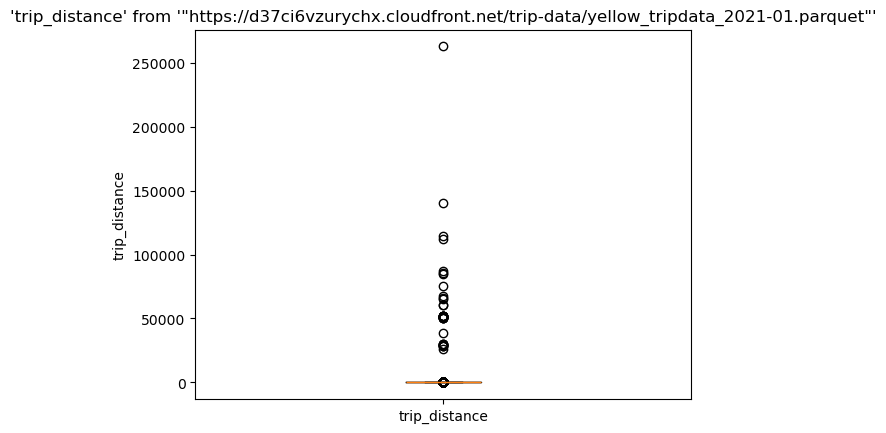

In [8]:
%sqlplot boxplot --table '"https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet"' --column trip_distance

In [11]:
%%sql --save short_trips --no-execute
SELECT *
FROM 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2021-01.parquet'
WHERE trip_distance < 6.3

Skipping execution...

<Axes: title={'center': "'trip_distance' from 'short_trips'"}, xlabel='trip_distance', ylabel='Count'>

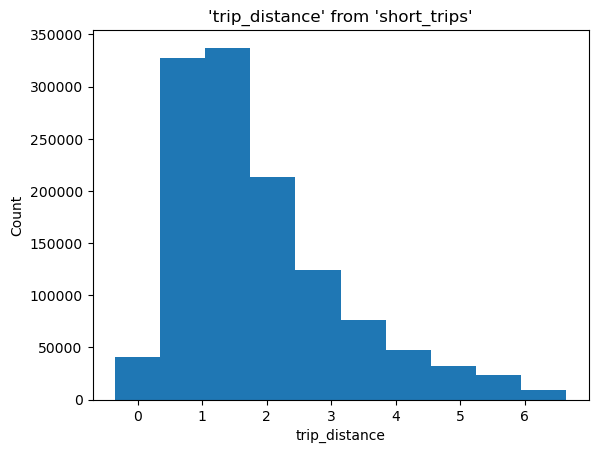

In [12]:
%sqlplot histogram --table short_trips --column trip_distance --bins 10 --with short_trips